In [53]:
import pandas as pd
import numpy as np 
import datetime as dt
import os as os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [54]:
execfile('./price_reader.py')

In [55]:
bucket_list = pd.read_csv('../data/sp_500_frtb_bucket',delimiter=' ')
tickers = bucket_list.ticker

begin_date = dt.date(2005,1,1)
end_date = dt.date(2016,1,1)

curr_dir = '../data/10-K/'
price_dir = '../data/PRICES/'
beta_dir = '../data/BETA/F-F_Research_Data_5_Factors_2x3_daily/'

price_files = os.listdir(curr_dir)
tickers = np.intersect1d(tickers, price_files)


tickers_filtered = []
#print tickers
for tic in tickers:
    this_file = price_dir + tic + '.pkl'
    beta_file = beta_dir + tic
    try :
        p = pd.read_pickle(this_file)
        b = pd.read_pickle(beta_file)
        
        b1 = p.index[0]
        e1 = p.index[-1]
        
        b2 = b.index[0]
        e2 = b.index[-1]
        
        if (b1.date() < begin_date) and e1.date() > (end_date) :
            if b2 < begin_date and e2 > end_date :
                tickers_filtered.append(tic)
    except:
        None

tickers = tickers_filtered  
#bucket_list_dict = { bucket_list.iloc[0]:bucket_list.iloc[i,1] for tic in range(bucket_list.shape[0])}
#bucket_list = { bucket_list[tic]:for tic in tickers}

tickers_filtered = []
for tic in tickers:
    p =  pd.read_pickle('../data/BETA/F-F_Research_Data_5_Factors_2x3_daily/'+tic)
    m = p.max(axis=0)
    
    if m[5] < 0.8:
        tickers_filtered.append(tic)

tickers = tickers_filtered        
print len(tickers)

371


In [56]:
bucket_list_dict = { bucket_list.iloc[i,0]:bucket_list.iloc[i,1] for i in range(bucket_list.shape[0]) if bucket_list.iloc[i,0] in tickers}
print len(bucket_list_dict)

371


In [57]:
def get_risks(tickers, begin_date, end_date ):
    print 'new one'
    factor_name = 'F-F_Research_Data_5_Factors_2x3_daily'
    
    fac_ret = pd.read_pickle('../data/FACTORS/F-F_Research_Data_5_Factors_2x3_daily.pkl')
    
    dates = [ d.date() for d in fac_ret.index ]
    fac_ret.index = dates
    
    ind = [ i for i,d in enumerate(fac_ret.index) if d > begin_date ]
    fac_ret = fac_ret.iloc[ind, :]
    
    ind = [ i for i,d in enumerate(fac_ret.index) if d < end_date ]
    fac_ret = fac_ret.iloc[ind, :]
    
    #fac_ret = fac_ret[fac_ret.index > begin_date]
    #fac_ret = fac_ret[fac_ret.index < end_date]

    fac_cov = get_factor_cov(factor_name, halflife = 252 )
    fac_mean = get_factor_mean(factor_name, halflife=252)
    

    
    tickers_beta_dic = {}
    tickers_vol_df = pd.DataFrame()
    

    
    for tic in tickers:
        p = pd.read_pickle('../data/BETA/F-F_Research_Data_5_Factors_2x3_daily/'+tic)
        ind = [ i for i,d in enumerate(p.index) if d > begin_date ]
        p = p.iloc[ind,:]
        ind = [ i for i,d in enumerate(p.index) if d < end_date ]
        p = p.iloc[ind, :]
        
        tickers_beta_dic[tic] = p.iloc[:,0:5]
        tickers_vol_df[tic] = p.iloc[:,-1]
     
    
    
    tickers_vol_df.dropna(how='any',axis=0, inplace = True)
    
    #print 'vol shape'
    #print tickers_vol_df.shape
    
    risks_df = pd.DataFrame()
    #min var portfolio
    #mean var portfolio
    #equal weighted portfolio
    
    run_dates = tickers_vol_df.index
    
    for date in run_dates :
        this_fac_cov = fac_cov.loc[date]
        this_fac_mean = fac_mean.loc[date]
        
        this_stocks_beta = pd.DataFrame()
        
        for tic in tickers :
            #print tic, date
            this_stocks_beta[tic] = tickers_beta_dic[tic].loc[date]
            
            
        var_1 = np.dot(this_fac_cov, this_stocks_beta )
        var_1 = np.dot(this_stocks_beta.T, var_1)
        
        var_2 = np.diag(tickers_vol_df.loc[date]*tickers_vol_df.loc[date])
        
        stocks_ret = np.dot(this_stocks_beta.T, fac_mean.loc[date] )
        
        total_var = var_1 + var_2
        
        pres_mat = np.linalg.inv(total_var)
        x1 = np.dot(pres_mat, np.ones(pres_mat.shape[0]))
        norm_1 = np.dot(np.ones(pres_mat.shape[0]), x1.transpose() )
        x2 = np.dot(pres_mat, stocks_ret )
        norm_2 = np.dot(np.ones(pres_mat.shape[0]),x2.transpose() )                          
        
        #print x1
        #print norm_1
        
        min_var_weights = x1/ norm_1
        mean_var_weights = x2/norm_2
        
        eq_weights = np.ones(pres_mat.shape[0])/pres_mat.shape[0]
                                      
        min_var_risk = np.sqrt( np.dot( np.dot(min_var_weights, total_var), min_var_weights ) )                               
                                      
        mean_var_risk = np.sqrt( np.dot( np.dot(mean_var_weights, total_var), mean_var_weights ) )                               
        eq_var_risk = np.sqrt( np.dot( np.dot(eq_weights, total_var), eq_weights ) )
        
        eig_val, eig_vec = np.linalg.eig(total_var)
        
        #ind = eig_val.argmax()
        #print 'ind'
        #print ind
        #print 'total var shape'
        #print total_var.shape
        
        #print 'eigen_vec shape'
        #print eig_vec.shape
        #eig_weights = eig_vec[ind,:]/( eig_vec[ind,:].sum() )
        #print eig_weights.shape
        
        #eig_sd = np.sqrt( np.dot(eig_weights, total_var), eig_weights )
        #print eig_sd.shape
        
        eig_sd = np.sqrt( np.max(eig_val)/np.sum(eig_val) )
        
        mean_sd = np.mean(tickers_vol_df.loc[date])
        #iid_sd = np.sqrt( np.mean( tickers_vol_df.loc[date]*tickers_vol_df.loc[date] ) )
        min_sd = np.min(tickers_vol_df.loc[date])
        max_sd = np.max(tickers_vol_df.loc[date])
        
        names = [ 'min_sd', 'mean_sd', 'max_sd', 'min_var_sd', 'mean_var_sd', 'eq_sd', 'avg_corr', 'eig_sd']

        sd_mat = np.array( [np.sqrt(total_var[i,i]) for i in range(total_var.shape[0]) ] )/eq_weights[0]

        c1 = ( np.sum( sd_mat*sd_mat ) )
        c2 = np.sum(sd_mat)*np.sum(sd_mat)
        c3 = c2 - c1
        
        avg_corr = ( eq_var_risk*eq_var_risk - c1 )/(c2 - c1) 

        vec = [ min_sd, mean_sd, max_sd, min_var_risk, mean_var_risk, eq_var_risk, avg_corr, eig_sd]
        
        vec = pd.Series(vec, index = names, name = date)
        risks_df = risks_df.append(vec)
                                      
    return risks_df                              
                                              
                                      



In [58]:
unique_buckets = np.unique( bucket_list.iloc[:,1] )
bucket_stocks = {}

for buc in unique_buckets :
    this_l = []
    for tic in tickers :
        if bucket_list_dict[tic] == buc :
            this_l.append(tic)

    bucket_stocks[buc] = this_l



In [59]:
for buc in unique_buckets :
    print len( bucket_stocks[buc]  )


154
61
44
111
1


new one


array(['EQ_5', 'EQ_6', 'EQ_7', 'EQ_8', 'EQ_9'], dtype=object)

In [60]:
x5 = get_risks(tickers = bucket_stocks['EQ_5'], begin_date = dt.date(2006,1,1), end_date= dt.date(2017,1,1) )
x6 = get_risks(tickers = bucket_stocks['EQ_6'], begin_date = dt.date(2006,1,1), end_date= dt.date(2016,1,1) )
x7 = get_risks(tickers = bucket_stocks['EQ_7'], begin_date = dt.date(2006,1,1), end_date= dt.date(2016,1,1) )
x8 = get_risks(tickers = bucket_stocks['EQ_8'], begin_date = dt.date(2006,1,1), end_date= dt.date(2016,1,1) )


new one
new one
new one
new one


In [71]:
n = x5.shape[0]


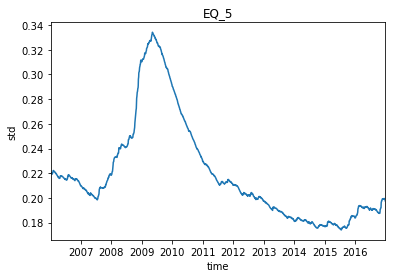

In [63]:
x5.mean_sd.plot()

pylab.title('EQ_5')
pylab.xlabel('time')
pylab.ylabel('std')
pylab.

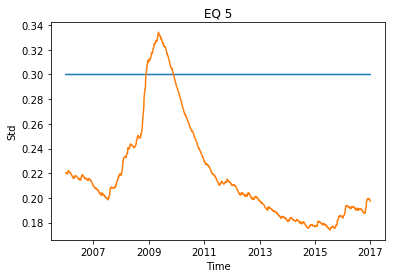

In [76]:
plt.plot(x5.index,[0.3 for k in range(n)])
plt.plot(x5.mean_sd)
plt.xlabel('Time')
plt.ylabel('Std')
plt.title('EQ 5')
plt.show()

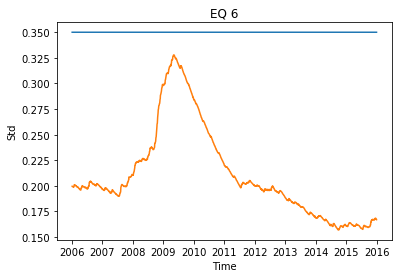

In [78]:
plt.plot(x6.index,[0.35 for k in range(2517)])
plt.plot(x6.mean_sd)
plt.xlabel('Time')
plt.ylabel('Std')
plt.title('EQ 6')
plt.show()

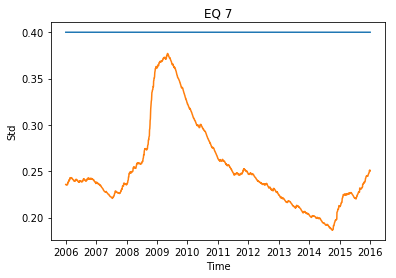

In [80]:
plt.plot(x7.index,[0.4 for k in range(2509)])
plt.plot(x7.mean_sd)
plt.xlabel('Time')
plt.ylabel('Std')
plt.title('EQ 7')
plt.show()

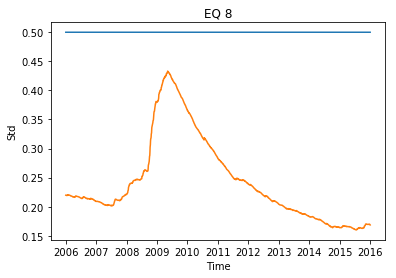

In [82]:
plt.plot(x8.index,[0.5 for k in range(2516)])
plt.plot(x8.mean_sd)
plt.xlabel('Time')
plt.ylabel('Std')
plt.title('EQ 8')
plt.show()

In [83]:
x5.describe()

,avg_corr,eig_sd,eq_sd,max_sd,mean_sd,mean_var_sd,min_sd,min_var_sd
count,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000
mean,-0.007328,0.189144,0.021531,0.536354,0.219335,0.049013,0.107239,0.017731
std,0.000120,0.035583,0.004536,0.097051,0.041084,0.779140,0.016321,0.003540
min,-0.007747,0.139388,0.016535,0.383022,0.174123,0.014477,0.084505,0.014174
25%,-0.007404,0.162763,0.018278,0.457239,0.189956,0.015914,0.096815,0.015283
50%,-0.007312,0.181516,0.019907,0.521625,0.208416,0.017822,0.103325,0.016259
75%,-0.007225,0.209015,0.022752,0.603249,0.234255,0.023786,0.110691,0.018573
max,-0.007149,0.301034,0.033974,0.780482,0.334215,33.168434,0.158388,0.027462


In [84]:
x6.describe()

,avg_corr,eig_sd,eq_sd,max_sd,mean_sd,mean_var_sd,min_sd,min_var_sd
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000
mean,-0.018014,0.245091,0.031198,0.422609,0.210820,0.035356,0.124409,0.027525
std,0.000143,0.016668,0.006939,0.107749,0.044356,0.066968,0.030370,0.005970
min,-0.018370,0.204536,0.022904,0.274511,0.157016,0.020678,0.087647,0.020249
25%,-0.018137,0.234075,0.026707,0.341933,0.179758,0.024419,0.103282,0.023621
50%,-0.018029,0.244765,0.029387,0.403501,0.199454,0.027572,0.113852,0.025631
75%,-0.017902,0.255589,0.033431,0.459670,0.226018,0.035459,0.136549,0.029304
max,-0.017692,0.287727,0.049333,0.740354,0.327622,2.550529,0.202881,0.042838


In [85]:
x7.describe()

,avg_corr,eig_sd,eq_sd,max_sd,mean_sd,mean_var_sd,min_sd,min_var_sd
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,-0.025055,0.242132,0.042655,0.420277,0.252957,0.052645,0.131948,0.036685
std,0.000343,0.014999,0.008585,0.073494,0.046706,0.236408,0.027127,0.007668
min,-0.026602,0.212604,0.031037,0.320249,0.186618,0.027125,0.095838,0.026743
25%,-0.025113,0.230418,0.037024,0.364718,0.224671,0.032082,0.104816,0.031481
50%,-0.024947,0.237300,0.039632,0.395235,0.239845,0.036380,0.132293,0.033890
75%,-0.024856,0.254621,0.044853,0.462360,0.262666,0.044563,0.142308,0.038594
max,-0.024626,0.290951,0.065090,0.609567,0.377084,10.759840,0.199502,0.056694


In [86]:
x8.describe()

,avg_corr,eig_sd,eq_sd,max_sd,mean_sd,mean_var_sd,min_sd,min_var_sd
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,-0.009932,0.187501,0.028955,0.494798,0.243284,0.059178,0.117827,0.024906
std,0.000241,0.018038,0.009316,0.120164,0.072526,0.465619,0.034601,0.007826
min,-0.010575,0.150876,0.018390,0.306444,0.160067,0.016930,0.083241,0.016385
25%,-0.009911,0.175633,0.022482,0.398001,0.193558,0.019790,0.095899,0.018552
50%,-0.009847,0.186785,0.025287,0.485219,0.217571,0.024989,0.100715,0.022431
75%,-0.009791,0.195516,0.032843,0.552156,0.270230,0.040896,0.124084,0.028642
max,-0.009635,0.247960,0.052968,0.781203,0.433117,19.323849,0.210046,0.043920


In [88]:
x5.describe()

,avg_corr,eig_sd,eq_sd,max_sd,mean_sd,mean_var_sd,min_sd,min_var_sd
count,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000
mean,-0.007328,0.189144,0.021531,0.536354,0.219335,0.049013,0.107239,0.017731
std,0.000120,0.035583,0.004536,0.097051,0.041084,0.779140,0.016321,0.003540
min,-0.007747,0.139388,0.016535,0.383022,0.174123,0.014477,0.084505,0.014174
25%,-0.007404,0.162763,0.018278,0.457239,0.189956,0.015914,0.096815,0.015283
50%,-0.007312,0.181516,0.019907,0.521625,0.208416,0.017822,0.103325,0.016259
75%,-0.007225,0.209015,0.022752,0.603249,0.234255,0.023786,0.110691,0.018573
max,-0.007149,0.301034,0.033974,0.780482,0.334215,33.168434,0.158388,0.027462


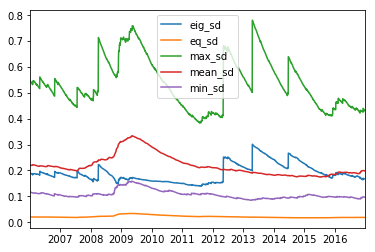

In [91]:
x5.iloc[:,[1,2,3,4,6]].plot()